In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

import seaborn as sns
sns.set_context('paper', font_scale = 1.5)
sns.color_palette('colorblind')

import h5py

import corner

#for approximating GW likelihood

from scipy.stats import gaussian_kde
from jaxinterp2d import interp2d

#for numpyro sampling

from jax import random
import numpyro
from numpyro.infer import MCMC, NUTS

#for calculating rates from GC models
import GC_rates

In [2]:
#read in GC model data
GC_data = GC_rates.read_data()

#read in GW population posterior
#use the GW likelihood by dividing posterior by the prior

with h5py.File('GW_dynrate_z0_z1.h5', 'r') as inp:
    GW_R0_post = np.array(inp['dyn_rate_z0'])
    GW_R1_post = np.array(inp['dyn_rate_z1'])
    GW_R0_prior = np.array(inp['dyn_rate_z0_prior'])
    GW_R1_prior = np.array(inp['dyn_rate_z1_prior'])

In [3]:
#define approximate GW likelihood
GW_R0R1_post = np.row_stack((np.log(GW_R0_post), np.log(GW_R1_post)))
GW_R0R1_joint_kde = gaussian_kde(GW_R0R1_post)

GW_R0R1_prior = np.row_stack((np.log(GW_R0_prior), np.log(GW_R1_prior)))
GW_R0R1_prior_joint_kde = gaussian_kde(GW_R0R1_prior)

logR0_grid = jnp.linspace(jnp.log(0.1), jnp.log(1000), 1000)
logR1_grid = jnp.linspace(jnp.log(0.1), jnp.log(1000), 1000)

R0p, R1p = jnp.meshgrid(logR0_grid, logR1_grid, indexing = "ij")

GW_R0R1_post_kde_grid = GW_R0R1_joint_kde.evaluate(np.row_stack((R0p.flatten(), R1p.flatten())))
GW_R0R1_prior_kde_grid = GW_R0R1_prior_joint_kde.evaluate(np.row_stack((R0p.flatten(), R1p.flatten())))


def GW_logpost(R0,R1):
    '''
    R0: BBH dynamics rate at z = 0
    R1: BBH dynamics rate at z = 1
    Returns the GW log likelihood at R0, R1
    '''
    return interp2d(jnp.log(R0), jnp.log(R1), logR0_grid, logR1_grid, jnp.log(GW_R0R1_post_kde_grid.reshape(1000,1000)) - jnp.log(GW_R0R1_prior_kde_grid.reshape(1000,1000)))

In [14]:
sigma_dex = 0.5 #spread in metallicity distribution at each redshift
Zsun = 0.02 #solar metallicity
logMlo = 2 #minimum GC mass is 10^2 Msun
logMhi = 8 #maximum GC mass is 10^8 Msun
dNdV0 = 2.31e9 #number density of evolved clusters *today* in Gpc^-3

def loglike(z_gc, a, b, mu_rv, sigma_rv, beta, logMstar0, logf_disrupted_cluster):
    
    R0 = GC_rates.merger_rate_at_z_pop(
        GC_data, 0, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, 
        beta, logMstar0, logMlo, logMhi)
    R1 = GC_rates.merger_rate_at_z_pop(
        GC_data, 1, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, 
        beta, logMstar0, logMlo, logMhi)
    return GW_logpost(R0, R1)

def prior(z_gc_bounds = [1, 8], a_bounds = [1,5], b_bounds = [1,5], 
          mu_rv_bounds = [0.5, 4], sigma_rv_bounds = [1, 3], 
          beta_bounds = [-4, 4], logMstar0_bounds = [5.5, 6.5],
          logf_disrupted_cluster_bounds = [0, 1.3], 
          fixed_mass_dist = False, beta_fixed = -2, logMstar0_fixed = 6.3):
    
    cluster_params = dict()
    
    cluster_params['z_gc'] = numpyro.sample('z_gc', numpyro.distributions.Uniform(low = z_gc_bounds[0], high = z_gc_bounds[1]))
    cluster_params['a'] = numpyro.sample('a', numpyro.distributions.Uniform(low = a_bounds[0], high = a_bounds[1]))
    cluster_params['b'] = numpyro.sample('b', numpyro.distributions.Uniform(low = b_bounds[0], high = b_bounds[1]))
    cluster_params['mu_rv'] = numpyro.sample('mu_rv', numpyro.distributions.Uniform(low = mu_rv_bounds[0], high = mu_rv_bounds[1]))
    cluster_params['sigma_rv'] = numpyro.sample('sigma_rv', numpyro.distributions.Uniform(low = sigma_rv_bounds[0], high = sigma_rv_bounds[1]))
    
    if fixed_mass_dist:
        cluster_params['beta'] = numpyro.deterministic('beta', beta_fixed)
        cluster_params['logMstar0'] = numpyro.deterministic('logMstar0', logMstar0_fixed)
        
    else:
        cluster_params['beta'] = numpyro.sample('beta', numpyro.distributions.Uniform(low = beta_bounds[0], high = beta_bounds[1]))
        cluster_params['logMstar0'] = numpyro.sample('logMstar0', numpyro.distributions.Uniform(low = logMstar0_bounds[0], high = logMstar0_bounds[1]))
    
    cluster_params['logf_disrupted_cluster'] = numpyro.sample('logf_disrupted_cluster', numpyro.distributions.Uniform(low = logf_disrupted_cluster_bounds[0], high = logf_disrupted_cluster_bounds[1]))
 
    return cluster_params


def posterior(z_gc_bounds = [1, 8], a_bounds = [1,5], b_bounds = [1,5], 
          mu_rv_bounds = [0.5, 4], sigma_rv_bounds = [1, 3], 
          beta_bounds = [-4, 4], logMstar0_bounds = [5.5, 6.5],
          logf_disrupted_cluster_bounds = [0, 1.3],
              fixed_mass_dist = False, beta_fixed = -2, logMstar0_fixed = 6.3):
    
    ll = loglike(**prior(z_gc_bounds, a_bounds, b_bounds, 
                         mu_rv_bounds, sigma_rv_bounds, beta_bounds,
                        logMstar0_bounds, logf_disrupted_cluster_bounds, 
                         fixed_mass_dist, beta_fixed, logMstar0_fixed))
    
    numpyro.factor('loglikelihood', ll)

In [21]:
sampler = MCMC(NUTS(posterior), num_warmup=64000, num_samples=64000, progress_bar = True)

sampler.run(random.PRNGKey(0), fixed_mass_dist = True)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 128000/128000 [24:56<00:00, 85.52it/s, 7 steps of size 4.37e-01. acc. prob=0.91]


In [22]:
samples_fixedmassdist = sampler.get_samples()
sampler.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
                       a      3.24      1.09      3.31      1.67      5.00  70147.74      1.00
                       b      2.97      1.15      2.96      1.00      4.58  78437.29      1.00
  logf_disrupted_cluster      0.37      0.19      0.36      0.03      0.64  48821.21      1.00
                   mu_rv      2.28      1.01      2.29      0.87      4.00  68123.98      1.00
                sigma_rv      2.01      0.58      2.02      1.16      2.96  72165.16      1.00
                    z_gc      4.78      1.94      4.88      2.02      8.00  69913.08      1.00

Number of divergences: 0


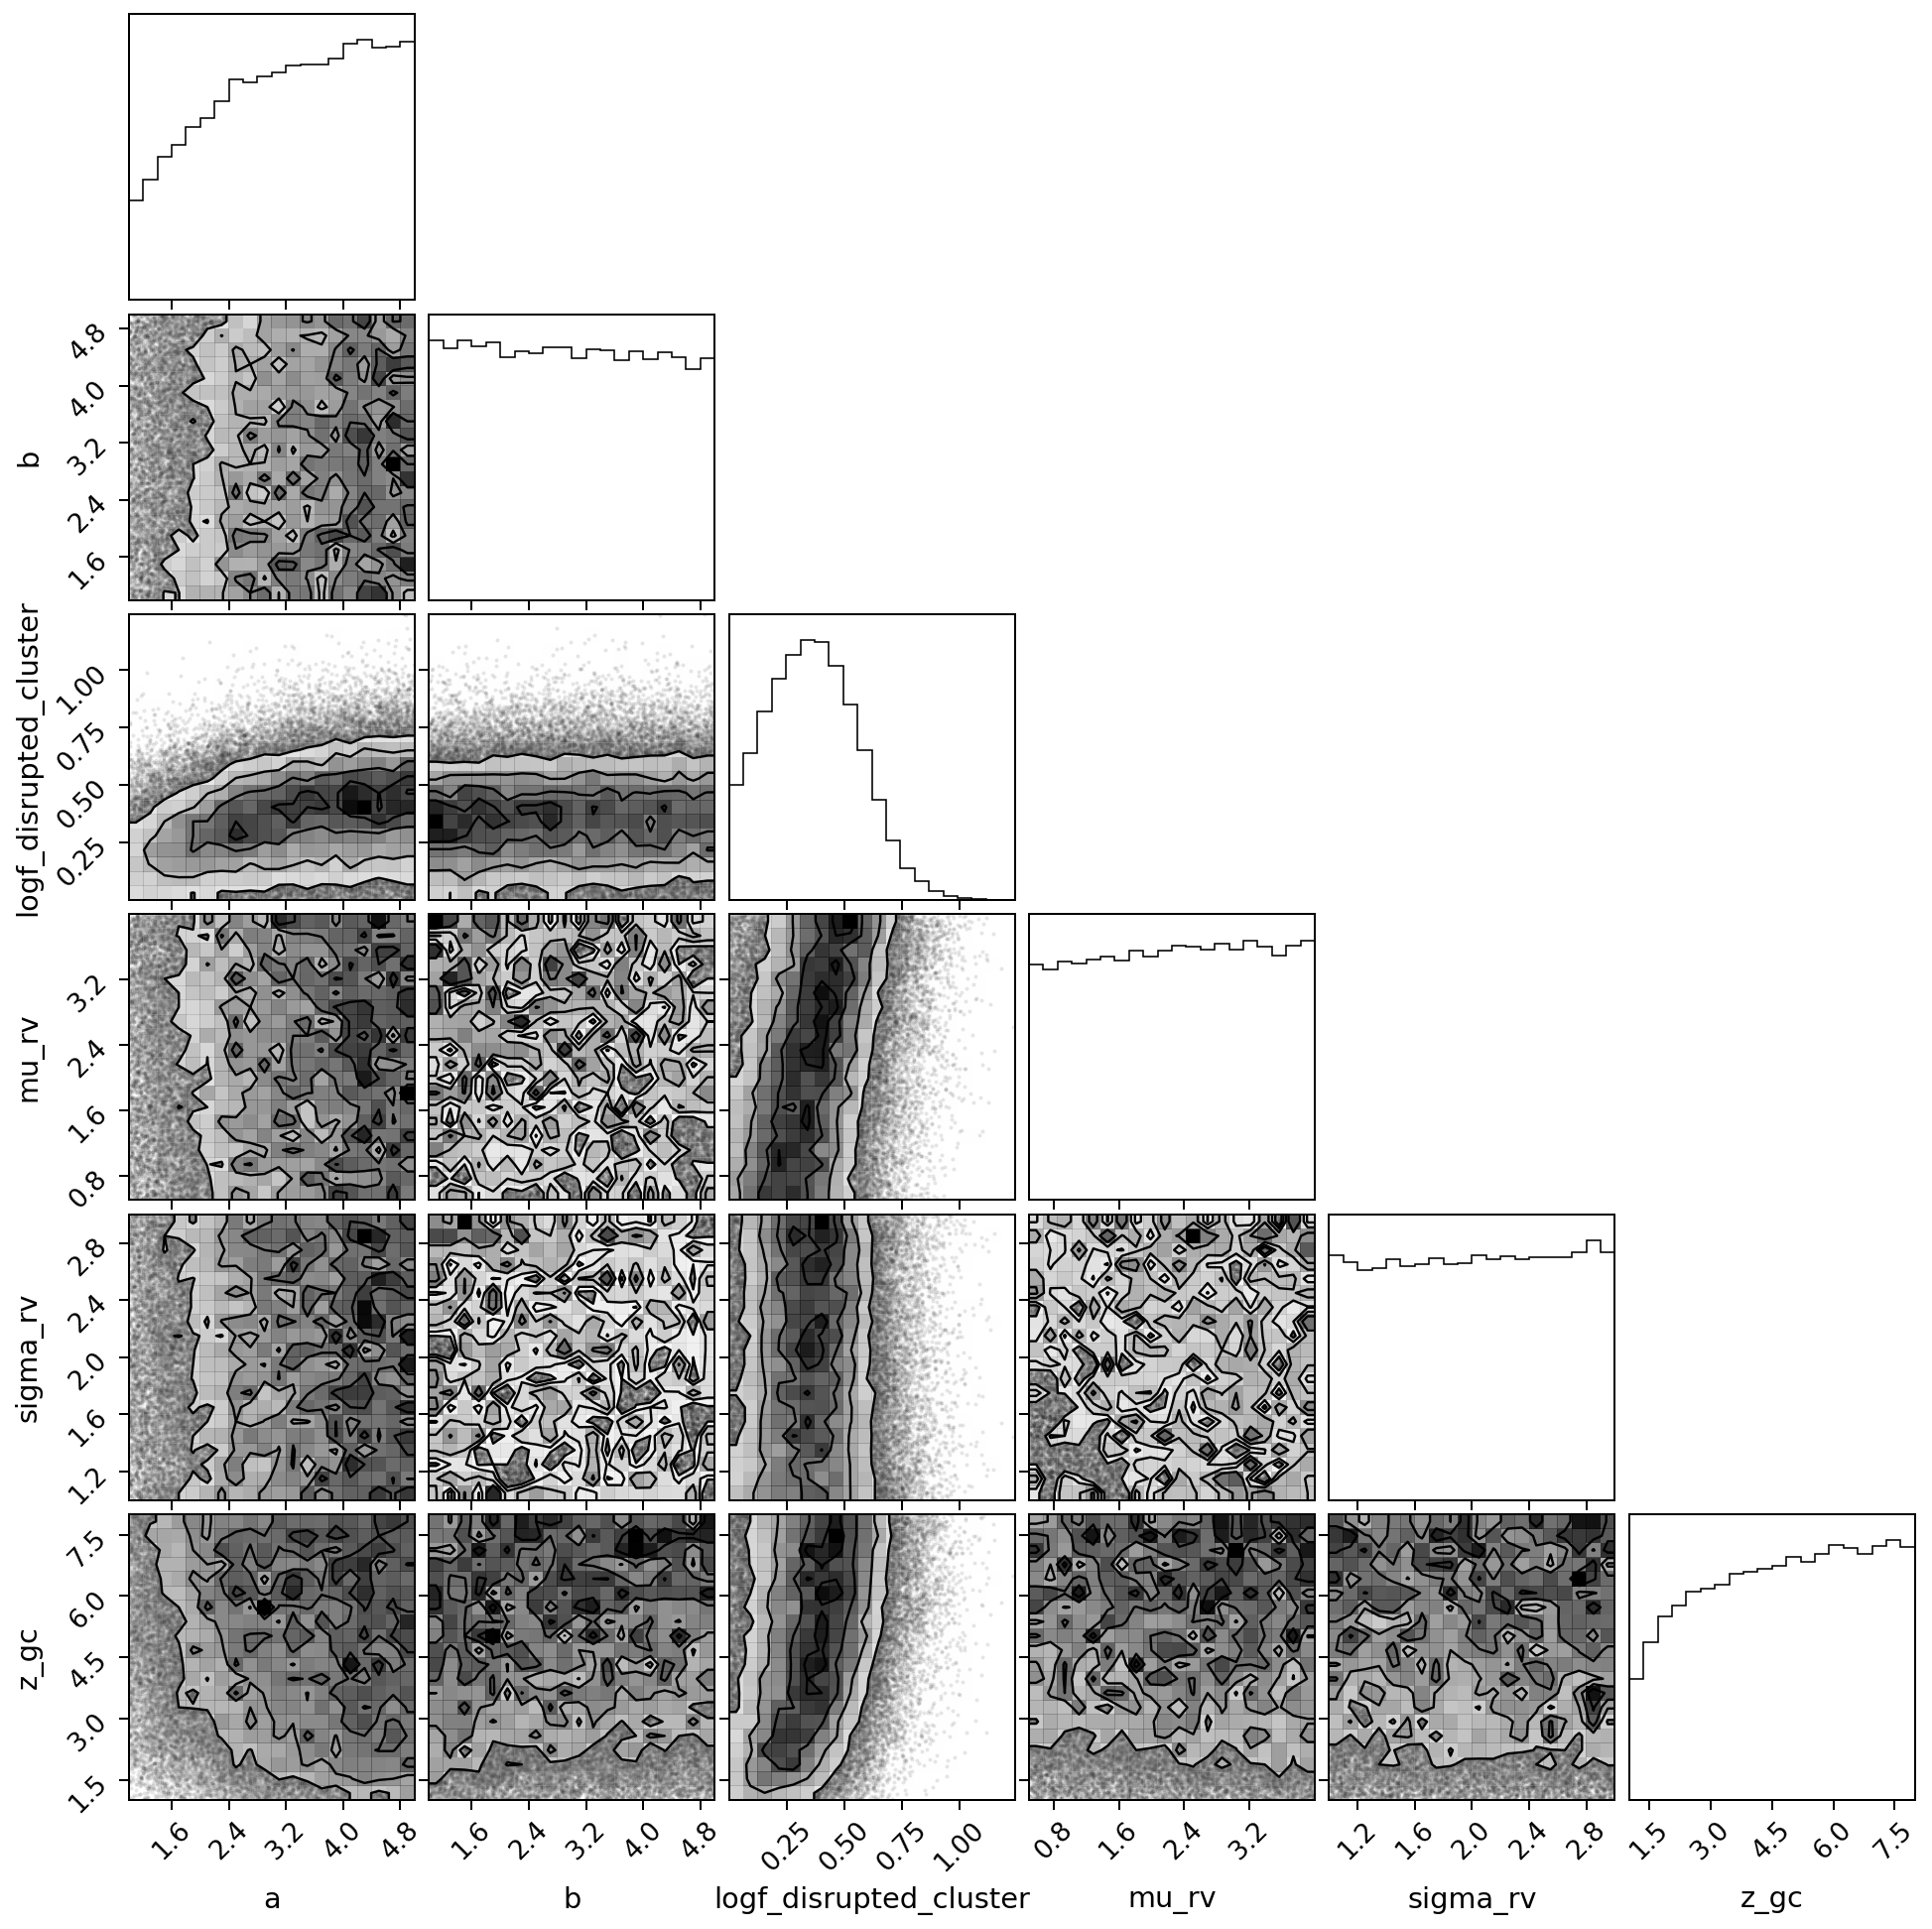

In [23]:
corner.corner(samples_fixedmassdist, var_names = ['a', 'b', 'logf_disrupted_cluster', 'mu_rv', 'sigma_rv', 'z_gc']);

In [24]:
with h5py.File('GC_properties_fixedmassdist.h5', 'w') as out:
    for n in samples_fixedmassdist.keys():
        out.create_dataset(name = n, data = samples_fixedmassdist[n])

In [5]:
sampler = MCMC(NUTS(posterior), num_warmup=8000, num_samples=8000, progress_bar = True)

sampler.run(random.PRNGKey(0))

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 16000/16000 [09:19<00:00, 28.60it/s, 31 steps of size 4.98e-02. acc. prob=0.92]


In [6]:
samples = sampler.get_samples()
sampler.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
                       a      3.30      1.04      3.37      1.82      5.00    867.82      1.00
                       b      2.98      1.16      2.96      1.19      4.77    911.28      1.00
                    beta     -1.92      0.41     -1.95     -2.60     -1.36    539.44      1.00
               logMstar0      6.26      0.12      6.25      6.07      6.45    528.20      1.00
  logf_disrupted_cluster      0.32      0.20      0.30      0.00      0.59    854.80      1.00
                   mu_rv      2.28      1.00      2.28      0.84      3.99    821.58      1.00
                sigma_rv      2.04      0.57      2.07      1.20      2.97   1065.00      1.00
                    z_gc      4.92      1.85      5.07      2.24      8.00   1216.69      1.00

Number of divergences: 6976


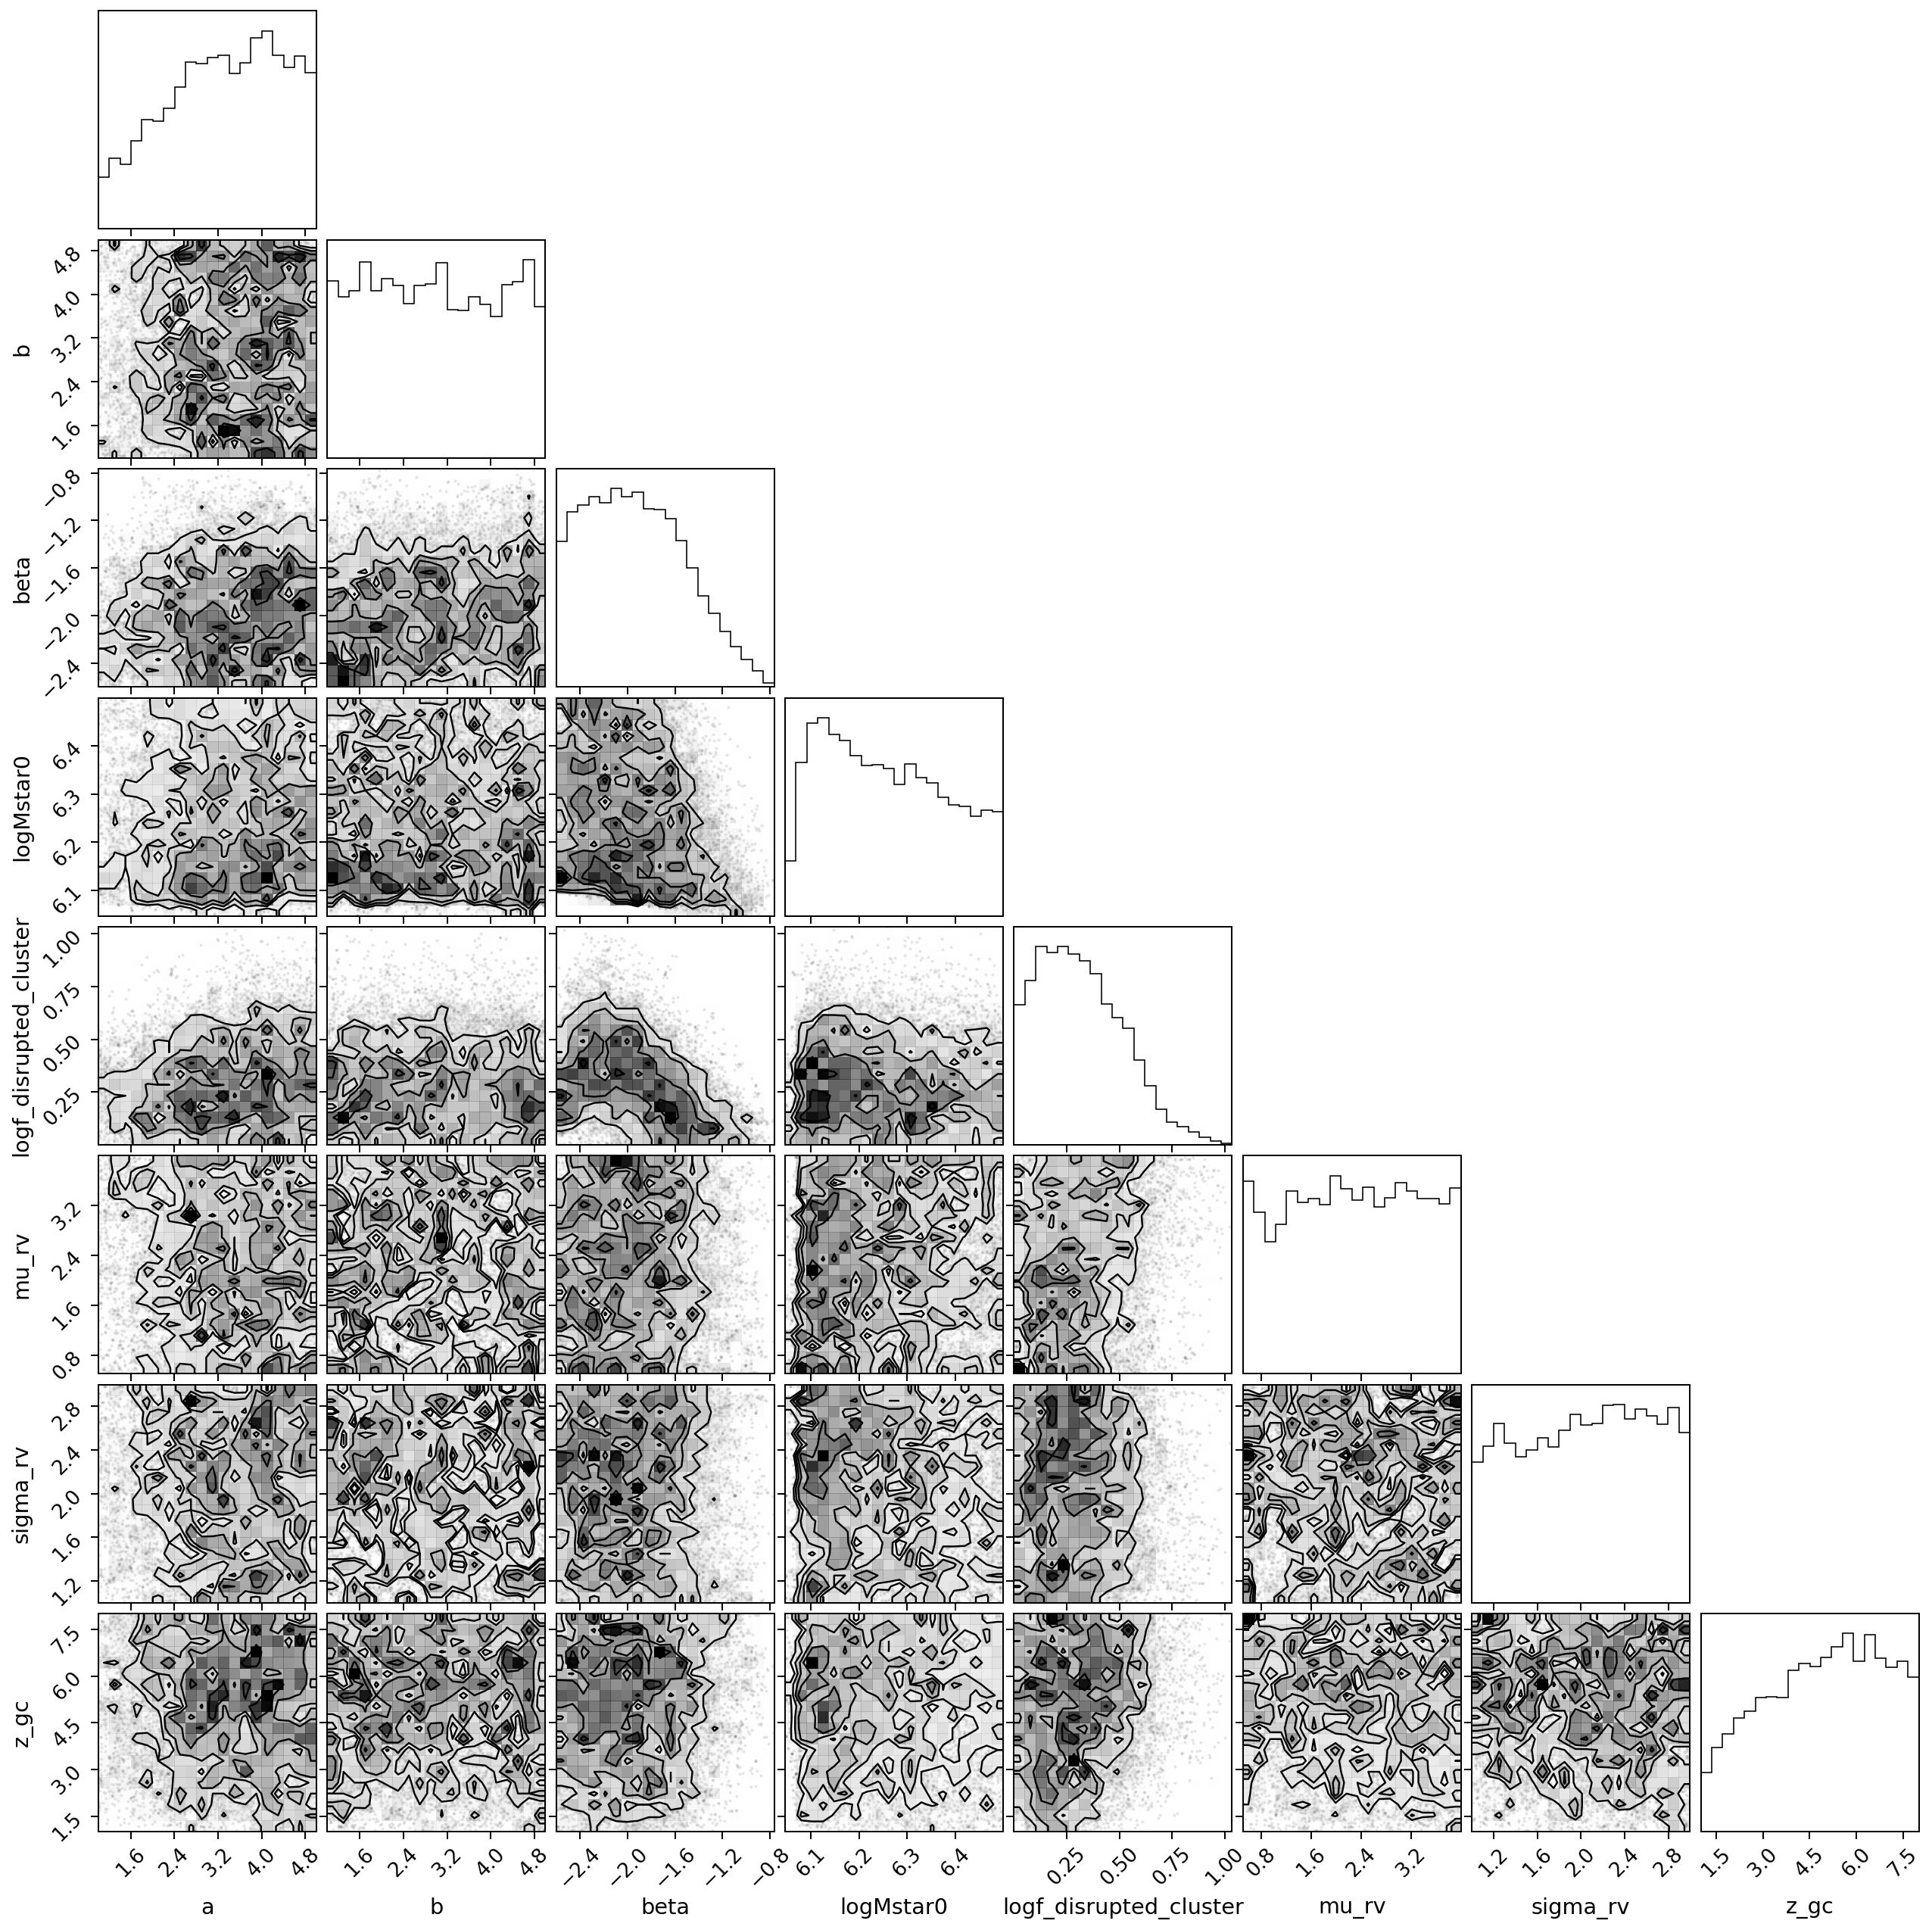

In [7]:
corner.corner(samples);

Text(0, 0.5, 'GC formation density [Gpc$^{-3}$ yr$^{-1}$]')

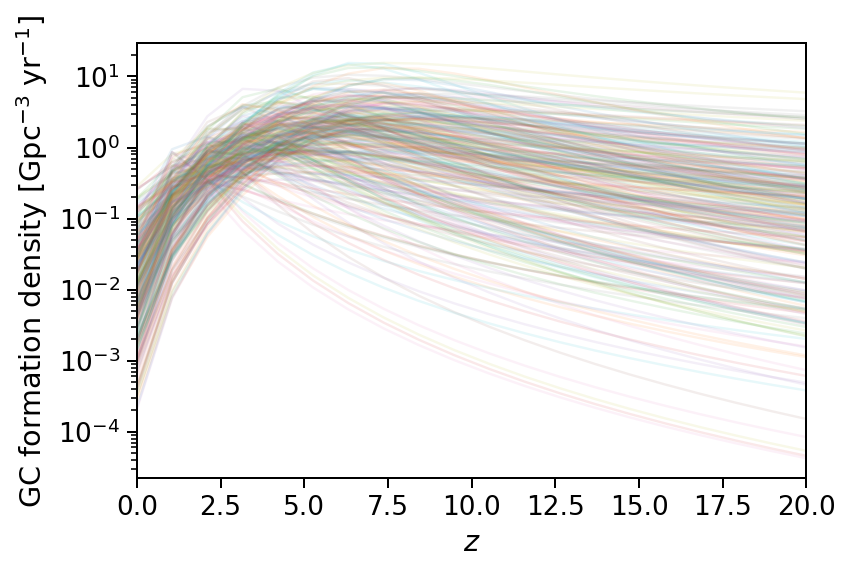

In [8]:
zs = np.linspace(0, 20, 20)
for i in np.random.choice(8000, size = 300):
    globular_formation = [GC_rates.sfr_at_z(zi, dNdV0, samples['z_gc'][i], samples['a'][i], samples['b'][i], 10**samples['logf_disrupted_cluster'][i]) for zi in zs]
    plt.plot(zs, globular_formation, alpha = 0.1)
    plt.yscale('log')

plt.xlim(0, 20)
plt.xlabel('$z$')
plt.ylabel(r'GC formation density [Gpc$^{-3}$ yr$^{-1}$]')